# GP-GAN for image blending
As described in paper: Gp-gan: Towards realistic high-resolution image blending

In [1]:
import os
COCO_API_DIR = 'D:/Datasets/COCO/cocoapi-master/PythonAPI'
COCO_ROOT = 'D:/Datasets/COCO/'
COCO_SET = 'train2017'
import sys
sys.path.append('../frontend')
sys.path.append('../backend')
sys.path.append(COCO_API_DIR)
import tensorflow as tf
from threading import Thread
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import glob
import time
from keras.layers import *
import pickle
import keras
from keras.models import *
from IPython.display import clear_output
import keras.backend as K
import keras.optimizers
import datasets
import composition
from pycocotools.coco import COCO

c:\anaconda\envs\ml\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


LEye is not present
REye is not present
LEar is not present
REar is not present
Nose is not present
Background is not present
HeadTop is not present
Neck is not present
Chest is not present
Pelvis is not present
Background is not present


In [2]:
# TO IMPLEMENT!
def get_weights_from_dict(name, weights_dict=None):
    w = None
    b = None
    return w, b

def dense(input, num, stddev=0.01, name='dense', weights_dict=None):
    with tf.variable_scope(name):
        w = None
        b = None
        if weights_dict is not None:
            for k in weights_dict.keys():
                if( name + '/weights' in k ):
                    print('Loaded weight from provided dict for layer: {}'.format(k))
                    w = tf.get_variable('weights', weights_dict[k].shape, initializer=tf.constant_initializer( weights_dict[k] ))
            if( name + '/biases' in k ):
                print('Loaded biases from provided dict for layer: {}'.format(k))
                b = tf.get_variable('biases', weights_dict[k].shape, initializer=tf.constant_initializer( weights_dict[k] ))

        if w is None:
            w = tf.get_variable('weights', [ input.get_shape()[-1], num ], initializer=tf.truncated_normal_initializer(stddev=stddev))
        if b is None:
            b = tf.get_variable('biases', [num], initializer=tf.zeros_initializer())

        return tf.nn.bias_add( tf.matmul( input, w ), b )
        
def conv2d(input, numkernels, kernel_size=[3,3], strides=[1,1,1,1],stddev=0.01,name='conv2d', weights_dict=None):
    with tf.variable_scope(name):
        
        w = None
        b = None
        if weights_dict is not None:
            for k in weights_dict.keys():
                if( name + '/weights' in k ):
                    print('Loaded weight from provided dict for layer: {}'.format(k))
                    w = tf.get_variable('weights', kernel_size+[ input.get_shape()[-1], numkernels ], initializer=tf.constant_initializer( weights_dict[k] ))
                if( name + '/biases' in k ):
                    print('Loaded biases from provided dict for layer: {}'.format(k))
                    b = tf.get_variable('biases', [numkernels], initializer=tf.constant_initializer( weights_dict[k] ))
                        
        if w is None:
            w = tf.get_variable('weights', kernel_size+[ input.get_shape()[-1], numkernels ], initializer=tf.truncated_normal_initializer(stddev=stddev))
        if b is None:
            b = tf.get_variable('biases', [numkernels], initializer=tf.zeros_initializer())
        
        conv = tf.nn.bias_add(tf.nn.conv2d(input, w, strides, padding='SAME'), b)
        return conv

def deconv2d(input, numkernels, output_size, kernel_size=[3,3], strides=[1,2,2,1], stddev=0.01, name='deconv2d', weights_dict=None):
    with tf.variable_scope(name):
        w = None
        b = None
        if weights_dict is not None:
            for k in weights_dict.keys():
                if( name + '/weights' in k ):
                    print('Loaded weight from provided dict for layer: {}'.format(k))
                    w = tf.get_variable('weights', kernel_size + [ numkernels, input.get_shape()[-1] ], initializer=tf.constant_initializer( weights_dict[k] ))
                if( name + '/biases' in k ):
                    print('Loaded biases from provided dict for layer: {}'.format(k))
                    b = tf.get_variable('biases', [numkernels], initializer=tf.constant_initializer( weights_dict[k] ))
        
        
        
        if w is None:
            w = tf.get_variable('weights', kernel_size + [ numkernels, input.get_shape()[-1] ], initializer=tf.truncated_normal_initializer(stddev=stddev))
        if b is None:
            b = tf.get_variable('biases', [numkernels], initializer=tf.zeros_initializer())
        deconv = tf.nn.bias_add(tf.nn.conv2d_transpose(input, w, output_shape=[ int(input.get_shape()[0]), output_size[0], output_size[1], numkernels ], strides=strides, padding='SAME'), b)
        return deconv
    
class CWGAN:
    
    
    def __init__(self, batch_size=4, z_dim=[64,64,6], y_dim=[64,64,3], weights_dict=None):
        self.batch_size = batch_size
        self.z_dim = z_dim
        self.y_dim = y_dim
        self.weights_dict = weights_dict
    
        
    def build_model(self):
        
        # PATHS:
        # GENERATOR IN AE Z_REAL->GEN->Y_REAL
        # GENERATOR IN ADVERSARIAL Z_FAKE->GEN->DIS->1
        # DISCRIMINATOR Z_FAKE->GEN, Y_REAL -> DIS -> 
        
        self.z_real = tf.placeholder(tf.float32, [None] + self.z_dim, name='z_real')
        self.z_fake = tf.placeholder(tf.float32, [None] + self.z_dim, name='z_fake')
        self.y_real = tf.placeholder(tf.float32, [None] + self.y_dim, name='y_real')
        
        self.G_adv = self.generator(self.z_fake, reuse=False, weights_dict=self.weights_dict)
        self.G_ae = self.generator(self.z_real, reuse=True, weights_dict=self.weights_dict)

        self.D_real, self.D_real_logits = self.discriminator( self.y_real, reuse=False, weights_dict=self.weights_dict)
        self.D_fake, self.D_fake_logits = self.discriminator( self.G_adv, reuse=True, weights_dict=self.weights_dict )
        
        # Define the loss 
        self.d_loss = tf.reduce_mean( self.D_fake_logits ) - tf.reduce_mean( self.D_real_logits )
        self.g_ae_loss = tf.reduce_mean( tf.abs(self.G_ae-self.y_real)  ) + 0.0001*tf.reduce_mean( tf.pow( self.G_ae-self.y_real ,2) )
        self.g_loss = -tf.reduce_mean( self.D_fake_logits ) 
        
        # Regularizer
#        self.reg = tc.layers.apply_regularization(tc.layers.l1_regularizer(0.1), weights_list=[ var for var in tf.global_variables() if 'weights' in var.name ])
#        self.g_loss += self.reg
 #       self.d_loss += self.reg
        
        
        t_vars = tf.trainable_variables()
        self.d_vars = [ var for var in t_vars if 'd_' in var.name ]
        self.g_vars = [ var for var in t_vars if 'g_' in var.name ]

        self.saver = tf.train.Saver()
        
    def discriminator(self, images, leak=0.2, reuse=False, weights_dict=None, kbase=32):
        with tf.variable_scope('discriminator') as scope:
            if(reuse):
                scope.reuse_variables()
            h0 = images
            h1 = tf.nn.leaky_relu( conv2d(h0, kbase, kernel_size=[3,3], strides=[1,1,1,1], name='d_h1', weights_dict=weights_dict), alpha=leak, name='d_h1_act' )
            h1_ds = tf.layers.max_pooling2d(h1, pool_size=[2,2], strides=[2,2], padding='SAME', name='d_h1_ds')
            h2 = tf.nn.leaky_relu( conv2d(h1_ds, kbase*2, kernel_size=[3,3], strides=[1,1,1,1], name='d_h2', weights_dict=weights_dict), alpha=leak, name='d_h2_act' )
            h2_ds = tf.layers.max_pooling2d(h2, pool_size=[2,2], strides=[2,2], padding='SAME', name='d_h2_ds')
            h3 = tf.nn.leaky_relu( conv2d(h2_ds, kbase*4, kernel_size=[3,3], strides=[1,1,1,1], name='d_h3', weights_dict=weights_dict), alpha=leak, name='d_h3_act' )
            h3_ds = tf.layers.max_pooling2d(h3, pool_size=[2,2], strides=[2,2], padding='SAME', name='d_h3_ds')
            h4 = tf.nn.leaky_relu( conv2d(h3_ds, kbase*8, kernel_size=[3,3], strides=[1,1,1,1], name='d_h4', weights_dict=weights_dict), alpha=leak, name='d_h4_act' )
            h4_ds = tf.layers.max_pooling2d(h4, pool_size=[2,2], strides=[2,2], padding='SAME', name='d_h4_ds')
            h5 = tf.nn.leaky_relu( conv2d(h4_ds, kbase*16, kernel_size=[3,3], strides=[1,1,1,1], name='d_h5', weights_dict=weights_dict), alpha=leak, name='d_h5_act' )
            h5_ds = tf.layers.max_pooling2d(h5, pool_size=[2,2], strides=[2,2], padding='SAME', name='d_h5_ds')

            h6 = tf.nn.leaky_relu( conv2d(h5_ds, 1, kernel_size=[3,3], strides=[1,1,1,1], name='d_h6', weights_dict=weights_dict), alpha=leak, name='d_h6_act' )
            h6_ds = tf.layers.max_pooling2d(h6, pool_size=[2,2], strides=[2,2], padding='SAME', name='d_h6_ds')

            logits = h6_ds
            out = tf.nn.sigmoid( logits, name='d_out' )
            return out, logits
    
    def generator(self, z, leak=0.2, reuse=False, weights_dict=None, kbase=32, kref=32):
        with tf.variable_scope('generator') as scope:
            if(reuse):
                scope.reuse_variables()

            # Get the sizes right
            size0 = [ int(z.get_shape()[1]), int(z.get_shape()[2]) ]
            size1 = [ int(p//2) for p in size0 ]
            size2 = [ int(p//2) for p in size1 ]
            size3 = [ int(p//2) for p in size2 ]
            size4 = [ int(p//2) for p in size3 ]
            
            # Downsampling parts
            ds0 = z
            ds1 = tf.layers.max_pooling2d(pool_size=[2,2], strides=[2,2], padding='SAME', inputs=tf.nn.leaky_relu(conv2d(ds0, kbase, strides=[1,1,1,1], name='g_ds1', weights_dict=weights_dict), alpha=leak, name='g_ds1_act'))
            ds2 = tf.layers.max_pooling2d(pool_size=[2,2], strides=[2,2], padding='SAME', inputs=tf.nn.leaky_relu(conv2d(ds1, kbase*2, strides=[1,1,1,1], name='g_ds2', weights_dict=weights_dict), alpha=leak, name='g_ds2_act'))
            ds3 = tf.layers.max_pooling2d(pool_size=[2,2], strides=[2,2], padding='SAME', inputs=tf.nn.leaky_relu(conv2d(ds2, kbase*4, strides=[1,1,1,1], name='g_ds3', weights_dict=weights_dict), alpha=leak, name='g_ds3_act'))
            ds4 = tf.layers.max_pooling2d(pool_size=[2,2], strides=[2,2], padding='SAME', inputs=tf.nn.leaky_relu(conv2d(ds3, kbase*8, strides=[1,1,1,1], name='g_ds4', weights_dict=weights_dict), alpha=leak, name='g_ds4_act'))
            ds5 = tf.layers.max_pooling2d(pool_size=[2,2], strides=[2,2], padding='SAME', inputs=tf.nn.leaky_relu(conv2d(ds4, kbase*16, strides=[1,1,1,1], name='g_ds5', weights_dict=weights_dict), alpha=leak, name='g_ds5_act'))

            # Reshaping to make sure we have proper upsampling
            ds5_shape = ds5.get_shape()
            ds5 = tf.reshape(ds5, [ self.batch_size, ds5_shape[1], ds5_shape[2], ds5_shape[3] ])
            
            # Upsampling blocks
            us4 = tf.nn.relu(deconv2d(ds5, kbase*16, output_size=size4, name='g_us4', weights_dict=weights_dict), name='g_us4_act')
            us3 = tf.nn.relu(deconv2d(us4, kbase*8, output_size=size3, name='g_us3', weights_dict=weights_dict), name='g_us3_act')
            us2 = tf.nn.relu(deconv2d(us3, kbase*4, output_size=size2, name='g_us2', weights_dict=weights_dict), name='g_us2_act')
            us1 = tf.nn.relu(deconv2d(us2, kbase*2, output_size=size1, name='g_us1', weights_dict=weights_dict), name='g_us1_act')
            us0 = tf.nn.relu(deconv2d(us1, kbase, output_size=size0, name='g_us0', weights_dict=weights_dict), name='g_us0_act')

            # Refinement blocks
            ref0 = tf.nn.relu(conv2d(tf.concat( [ z, us0 ], axis=3 ), kref, strides=[1,1,1,1], name='g_ref0', weights_dict=weights_dict), name='g_ref0_act')
            ref1 = tf.nn.relu(conv2d(tf.concat( [ z, us0, ref0 ], axis=3 ), kref, strides=[1,1,1,1], name='g_ref1', weights_dict=weights_dict), name='g_ref1_act')
            ref2 = tf.nn.relu(conv2d(tf.concat( [ z, us0, ref0, ref1 ], axis=3 ), kref, strides=[1,1,1,1], name='g_ref2', weights_dict=weights_dict), name='g_ref2_act')
            ref3 = tf.nn.relu(conv2d(tf.concat( [ z, us0, ref0, ref1, ref2 ], axis=3 ), kref, strides=[1,1,1,1], name='g_ref3', weights_dict=weights_dict), name='g_ref3_act')
            
            out = conv2d(ref3, self.y_dim[-1], strides=[1,1,1,1], name='g_out', weights_dict=weights_dict)
            out = tf.clip_by_value(out, 0, 255)
            return out

    def get_weights(self, sess):
        weights=dict()
        for var in self.d_vars:
            weights[var.name] = var.eval()
        for var in self.g_vars:
            weights[var.name] = var.eval()
        return weights
        





In [3]:
def plot_progress(progress:list, past:int=1000, show:bool=True):
    p = np.array(progress)
    p = p[ np.max([0, p.shape[0]-past]): ]
    plt.plot(p[:,0], p[:,1])
    plt.plot(p[:,0], p[:,2])
    plt.plot(p[:,0], p[:,3])
    plt.grid()
#    plt.legend(['d_loss: {}'.format(p[-1,1]), 'g_loss: {}'.format(p[-1,2]) ])
    plt.legend(['d_loss: {}'.format(p[-1,1]), 'g_loss: {}'.format(p[-1,2]), 'ae_loss: {}'.format(p[-1,3])])
    plt.title('Progress for the last {} iterations'.format(past))
    if show:
        plt.show()

In [4]:
annFile='{}/annotations/instances_{}.json'.format(COCO_ROOT,COCO_SET)
annFileKPS = '{}/annotations/person_keypoints_{}.json'.format(COCO_ROOT,COCO_SET)
catNms = ['person']
coco=COCO(annFile)
coco_kps=COCO(annFileKPS)  
catIds = coco.getCatIds(catNms)
imgIds = coco.getImgIds(catIds=catIds )

loading annotations into memory...
Done (t=33.40s)
creating index...
index created!
loading annotations into memory...
Done (t=14.96s)
creating index...
index created!


In [8]:
composition_params = composition.default_composition_params
composition_params['longer_edge_size'] = 64
composition_params['allow_overlaps_in_A'] = True
composition_params['allow_overlaps_in_B'] = True
composition_params['max_occ_perc_th'] = 0.99
composition_params['overlap_perc_th'] = 0.99

composition_params['image_interpolation'] = cv2.INTER_CUBIC


In [39]:
def get_real_examples(list_out, coco, coco_kps, coco_root, imgIds, catIds, params, batch_size):
    print('Starting the real examples thread')
    # GET REFERENCE, NATURAL LOOKING EXAMPLES
    for i in range(0, batch_size):
        IM = composition.get_image_suitable_for_blending_with_meta(coco, coco_kps, coco_root, imgIds, catIds, longer_edge_size=params['longer_edge_size'], scale_range=params['scale_range_A'], shift_range=params['shift_range_A'], rot_range=params['rot_range_A'], allow_overlaps=params['allow_overlaps_in_A'], image_interpolation=params['image_interpolation'])

        # Kkernel for dilation / erosion
        kernel = np.ones((3,3),np.uint8)
        
        # Id of the mask selected 
        mid = np.random.uniform(0, len(IM['masks']), (1,)).astype(np.int32)[0]
        
        # Mask itself - all white in RGB
        m = np.stack( [255*(IM['masks'][mid]>0)]*3, axis=2)
        
        # Random chance of nothing, expansion, erosion
        mmod = np.random.uniform(0,1,(1,))[0]
        if mmod > 0.66:
            # expansion
            m = cv2.dilate(m.astype(np.uint8),kernel,iterations = 1)
        elif mmod > 0.33:
            # erosion
            m = cv2.erode(m.astype(np.uint8),kernel,iterations = 1)
        
        
        # Filtering the mask to make it smooth
        #avgkernel = np.ones((3,3),np.float32)/9
        #m = cv2.filter2D(m.astype(np.uint8),-1,avgkernel)
        
        # Normalize to 0-1
        m = m/255
        
        masked_image = np.multiply(IM['image_scaled_and_padded'], 1-m) + 255*m
        
        # Random perturbation of the mean
        ms = np.random.uniform(-5,5, (1,))[0]
        impainted_image = np.multiply(IM['image_scaled_and_padded']+ms, m)
        
        
        
        IM['masked_image'] = np.clip(masked_image, 0, 255)
        IM['impainted_image'] = np.clip(impainted_image,0,255)
        
        list_out.append(IM)
    print('Real examples done')

def get_fake_examples(list_out, coco, coco_kps, coco_root, imgIds, catIds, params, batch_size):
    print('Starting the fake examples thread')
    # GET GENERATED EXAMPLES
    for i in range(0, batch_size):
        while True:
            data_train = composition.get_composition(coco, coco_kps,coco_root, imgIds, catIds, params=params)
            if data_train is not None:
                m = np.stack([255*(data_train['inserted_mask']>0)]*3, axis=2)
                masked_image = np.multiply(data_train['A']['image_scaled_and_padded'], m==0) + m
                impainted_image = np.multiply( data_train['B']['image_scaled_and_padded'], m!=0 )
                
                
                
                data_train['masked_image'] = masked_image
                data_train['impainted_image'] = impainted_image
                list_out.append(data_train)
                break
    print('Fake examples done')
    

def get_training_examples(coco, coco_kps, coco_root, imgIds, catIds, composition_params, batch_size):
    
    list_real = list()
    list_fake = list()
    thread_real = Thread(target=get_real_examples, args=(list_real, coco, coco_kps, coco_root, imgIds, catIds, composition_params, batch_size))
    thread_fake = Thread(target=get_fake_examples, args=(list_fake, coco, coco_kps, coco_root, imgIds, catIds, composition_params, batch_size))
    
    thread_real.start()
    thread_fake.start()

    thread_real.join()
    thread_fake.join()
    return np.array(list_real), np.array(list_fake)

def trim_weights(model):
    for l in model.layers:
        w = l.get_weights()
        if len(w) > 0:
            print(w[0].shape)
            weights = np.clip(w[0], -0.01, 0.01)
            l.set_weights([ weights, w[1] ])


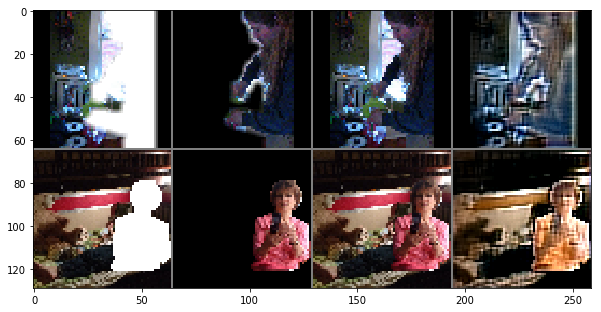

Saving weights


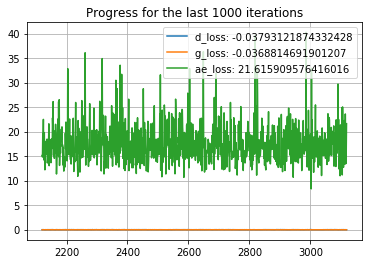

Starting the real examples threadStarting the fake examples thread

Real examples done
AE LOSS: 23.23851203918457
DIS LOSS: -0.007389329373836517
GEN LOSS: -0.039762213826179504
Fake examples done
Starting the real examples thread
Starting the fake examples thread
AE LOSS: 19.459482192993164
DIS LOSS: -0.027171730995178223
GEN LOSS: -0.02909773588180542
Fake examples done
Real examples done


KeyboardInterrupt: 

In [38]:
batch_size = 2
y_dim = [64,64,3]
z_dim = [64,64,6]

tf.reset_default_graph()
#wgan = CWGAN(batch_size=batch_size, z_dim=z_dim, y_dim=y_dim)
wgan = CWGAN(weights_dict=weights, batch_size=batch_size, z_dim=z_dim, y_dim=y_dim)
wgan.build_model()
it = 0
progress = []
provideNewExamples = True

with tf.Session() as sess:


    d_optim = tf.train.AdamOptimizer(0.00000001).minimize( wgan.d_loss, var_list=wgan.d_vars )
    g_optim = tf.train.AdamOptimizer(0.00000001).minimize( wgan.g_loss, var_list=wgan.g_vars )
    g_ae_optim = tf.train.AdamOptimizer(0.00000001).minimize( wgan.g_ae_loss, var_list=wgan.g_vars )

    d_clip = tf.group(*[v.assign(tf.clip_by_value(
        v, -0.001, 0.001)) for v in wgan.d_vars])
    
    sess.run( tf.global_variables_initializer() )


    while True:
        
        if provideNewExamples:
            list_real = list()
            list_fake = list()
            thread_real = Thread(target=get_real_examples, args=(list_real, coco, coco_kps, COCO_ROOT, imgIds, catIds, composition_params, batch_size))
            thread_fake = Thread(target=get_fake_examples, args=(list_fake, coco, coco_kps, COCO_ROOT, imgIds, catIds, composition_params, batch_size))
            thread_real.start()
            thread_fake.start()
        
        if it > 0:
            # AUTOENCODER TRAINING
            ae_loss_cur = 0
            _, ae_loss_cur = sess.run([g_ae_optim, wgan.g_ae_loss], feed_dict={ wgan.z_real:x_gt, wgan.y_real:y_gt })
        
            # DISCRIMINATOR TRAINING
            _, d_loss_cur,_ = sess.run([ d_optim, wgan.d_loss, d_clip ], feed_dict={ wgan.z_fake:x_fake, wgan.y_real:y_gt })

            # GENERATOR TRAINING
            _, g_loss_cur = sess.run([ g_optim, wgan.g_loss ], feed_dict={ wgan.z_fake:x_fake })


            # JOINTLY
#            _, ae_loss_cur, _, d_loss_cur,_,_, g_loss_cur = sess.run([g_ae_optim, wgan.g_ae_loss, d_optim, wgan.d_loss, d_clip, g_optim, wgan.g_loss], 
#                                            feed_dict={ wgan.z_real:x_gt, wgan.y_real:y_gt, wgan.z_fake:x_fake })
            
            
            print('AE LOSS: {}'.format(ae_loss_cur))
            print('DIS LOSS: {}'.format(d_loss_cur))
            print('GEN LOSS: {}'.format(g_loss_cur))


            progress.append([ it, d_loss_cur, g_loss_cur, ae_loss_cur ])

        if provideNewExamples:
            thread_real.join()
            thread_fake.join()
            examples_real = np.array(list_real)
            examples_fake = np.array(list_fake)
            
            x_gt = np.stack( [ np.concatenate([examples_real[i]['masked_image'], examples_real[i]['impainted_image']],2) for i in range(0,batch_size)], axis=0 )
            y_gt = np.stack( [ examples_real[i]['image_scaled_and_padded'] for i in range(0,batch_size)], axis=0 )
            x_fake = np.stack( [ np.concatenate([examples_fake[i]['masked_image'], examples_fake[i]['impainted_image']],2) for i in range(0,batch_size)], axis=0 )
            y_fake = np.stack( [ examples_fake[i]['image_scaled_and_padded'] for i in range(0,batch_size)], axis=0 )
        
        it = it+1

        if(it % 10 == 0):
            clear_output() 

            net_input = np.stack([ x_gt[0], x_fake[0] ], axis=0)
            net_output = sess.run( wgan.G_ae, feed_dict={wgan.z_real: net_input} )

            vsep = np.zeros((64,1,3)) + 127
            r = np.concatenate([ x_gt[0][:,:,0:3], vsep, x_gt[0][:,:,3:], vsep, y_gt[0],vsep,net_output[0] ],1)
            f = np.concatenate([ x_fake[0][:,:,0:3], vsep, x_fake[0][:,:,3:], vsep, y_fake[0],vsep, net_output[1] ],1)
            hsep = np.zeros((1,f.shape[1],3)) + 127
            c = np.concatenate( [r,hsep,f], 0 )

            plt.figure(figsize=(10,10))
            plt.imshow(c.astype(np.uint8))
            plt.show()

            
            
            weights = wgan.get_weights(sess)
            with open('wgan_weights.pickle', 'wb') as file:
                print('Saving weights')
                pickle.dump(weights, file)

            plot_progress(progress, past=1000, show=True)

In [ ]:
cv2.resize()

In [ ]:
print(wgan.D_fake_logits)

In [ ]:
cv2.INTER_NEAREST